# CS483 - Colab 4
## Collaborative Filtering

This code is written by Parikha Goyanka
Resources take in help if required: Goog search, Stackoverflow, Gfg, W3School

In [1]:
from IPython.display import Image
print("Colab 4 Mascot")
Image(url='https://media4.giphy.com/media/wtdVYmaRWJ1PyPcc8e/giphy.gif?cid=ecf05e478jdbzo92b89f2b5ud5184xda9cen1xce4bwmjeyu&ep=v1_stickers_search&rid=giphy.gif&ct=s',width=150)

Colab 4 Mascot


### Setup

Let's set up Spark on your Colab environment.  Run the cell below!

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u422-b05-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Now we authenticate a Google Drive client to download the files we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
id='1QtPy_HuIMSzhtYllT3-WeM3Sqg55wK_D'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('MovieLens.training')

id='1ePqnsQTJRRvQcBoF2EhoPU8CU1i5byHK'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('MovieLens.test')

id='1ncUBWdI5AIt3FDUJokbMqpHD2knd5ebp'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('MovieLens.item')

If you executed the cells above, you should be able to see the dataset we will use for this Colab under the "Files" tab on the left panel.

Next, we import some of the common libraries needed for our task.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [7]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [8]:
spark

### Data Loading

In this Colab, we will be using the [MovieLens dataset](https://grouplens.org/datasets/movielens/), specifically the 100K dataset (which contains in total 100,000 ratings from 1000 users on ~1700 movies).

We load the ratings data in a 80%-20% ```training```/```test``` split, while the ```items``` dataframe contains the movie titles associated to the item identifiers.

In [9]:
schema_ratings = StructType([
    StructField("user_id", IntegerType(), False),
    StructField("item_id", IntegerType(), False),
    StructField("rating", IntegerType(), False),
    StructField("timestamp", IntegerType(), False)])

schema_items = StructType([
    StructField("item_id", IntegerType(), False),
    StructField("movie", StringType(), False)])

training = spark.read.option("sep", "\t").csv("MovieLens.training", header=False, schema=schema_ratings)
test = spark.read.option("sep", "\t").csv("MovieLens.test", header=False, schema=schema_ratings)
items = spark.read.option("sep", "|").csv("MovieLens.item", header=False, schema=schema_items)

In [10]:
training.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- item_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- timestamp: integer (nullable = true)



In [11]:
items.printSchema()

root
 |-- item_id: integer (nullable = true)
 |-- movie: string (nullable = true)



### Your task

Let's compute some stats!  What is the number of ratings in the training and test dataset? How many movies are in our dataset?

In [33]:
print("************************** Overview Stats **************************\n")
print("Shape of the training dataset: ", (training.count(), len(training.columns)))
print("Shape of the testing dataset: ", (test.count(), len(test.columns)))

print("\n************************** Rating Stats **************************\n")
# Calculating total no of ratings in both sets
num_ratings_train = training.count()
num_ratings_test = test.count()

# Calculating distinct count of movies in the dataset
total_movies = items.select("item_id").distinct().count()

print(f"Total ratings in the training set: {num_ratings_train}")
print(f"Total ratings in the test set: {num_ratings_test}")
print(f"Total distinct movies: {total_movies}")

print("\n************************** User Stats **************************\n")
# Calculating no of unique users in both datasets
unique_train_users = training.select("user_id").distinct().count()
unique_test_users = test.select("user_id").distinct().count()
print(f"Unique users in the training dataset: {unique_train_users}")
print(f"Unique users in the testing dataset: {unique_test_users}")

print("\n************************** Average Ratings per User **************************\n")
# Calculating avg no of ratings each user has given
avg_ratings_per_user_train = training.groupBy("user_id").count().agg(avg("count")).first()[0]
avg_ratings_per_user_test = test.groupBy("user_id").count().agg(avg("count")).first()[0]
print(f"Average ratings per user in the training set: {avg_ratings_per_user_train:.2f}")
print(f"Average ratings per user in the test set: {avg_ratings_per_user_test:.2f}")

print("\n************************** Average Ratings per Movie **************************\n")
# Calculating avg no of ratings per movie
avg_ratings_per_movie_train = training.groupBy("item_id").count().agg(avg("count")).first()[0]
avg_ratings_per_movie_test = test.groupBy("item_id").count().agg(avg("count")).first()[0]
print(f"Average ratings per movie in the training set: {avg_ratings_per_movie_train:.2f}")
print(f"Average ratings per movie in the test set: {avg_ratings_per_movie_test:.2f}")

************************** Overview Stats **************************

Shape of the training dataset:  (80000, 4)
Shape of the testing dataset:  (20000, 4)

************************** Rating Stats **************************

Total ratings in the training set: 80000
Total ratings in the test set: 20000
Total distinct movies: 1682

************************** User Stats **************************

Unique users in the training dataset: 943
Unique users in the testing dataset: 459

************************** Average Ratings per User **************************

Average ratings per user in the training set: 84.84
Average ratings per user in the test set: 43.57

************************** Average Ratings per Movie **************************

Average ratings per movie in the training set: 48.48
Average ratings per movie in the test set: 14.18



************************** Rating Distribution Stats **************************



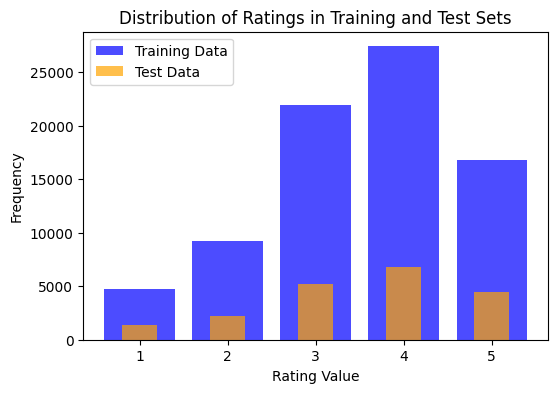

In [34]:
# Data preparation: Analyzing rating distribution
print("\n************************** Rating Distribution Stats **************************\n")
# Distribution of ratings (counting of 1-star, 2-star, etc. ratings)
train_rating_dist = training.groupBy("rating").count().orderBy("rating").collect()
test_rating_dist = test.groupBy("rating").count().orderBy("rating").collect()

# Calculating counts from the collected data
train_dist_values = [entry['count'] for entry in train_rating_dist]
test_dist_values = [entry['count'] for entry in test_rating_dist]
rating_labels = [entry['rating'] for entry in train_rating_dist]

# Ploting chart for training and test datasets
plt.figure(figsize=(6, 4))
plt.bar(rating_labels, train_dist_values, alpha=0.7, label='Training Data', color='blue')
plt.bar(rating_labels, test_dist_values, alpha=0.7, label='Test Data', color='orange', width=0.4)

# cosmetic changes
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings in Training and Test Sets')
plt.legend()
plt.show()



************************** Rating Distribution Stats II  **************************



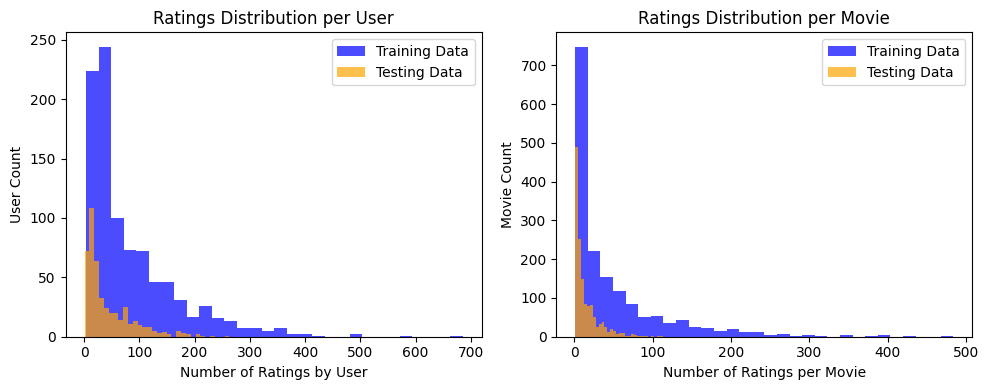

In [35]:
# data prep for training and testing sets
print("\n************************** Rating Distribution Stats II  **************************\n")
user_ratings_train = training.groupBy("user_id").count().select("count").collect()
user_ratings_test = test.groupBy("user_id").count().select("count").collect()

movie_ratings_train = training.groupBy("item_id").count().select("count").collect()
movie_ratings_test = test.groupBy("item_id").count().select("count").collect()

# Changing into lists
user_ratings_train_list = [entry['count'] for entry in user_ratings_train]
user_ratings_test_list = [entry['count'] for entry in user_ratings_test]

movie_ratings_train_list = [entry['count'] for entry in movie_ratings_train]
movie_ratings_test_list = [entry['count'] for entry in movie_ratings_test]

# Set up side-by-side plots to compare distributions
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Ploting chart for both the training and test datasets
axs[0].hist(user_ratings_train_list, bins=30, alpha=0.7, label='Training Data', color='blue')
axs[0].hist(user_ratings_test_list, bins=30, alpha=0.7, label='Testing Data', color='orange')
axs[0].set_title('Ratings Distribution per User')
axs[0].set_xlabel('Number of Ratings by User')
axs[0].set_ylabel('User Count')
axs[0].legend()

# Ploting chart for both the training and test datasets
axs[1].hist(movie_ratings_train_list, bins=30, alpha=0.7, label='Training Data', color='blue')
axs[1].hist(movie_ratings_test_list, bins=30, alpha=0.7, label='Testing Data', color='orange')
axs[1].set_title('Ratings Distribution per Movie')
axs[1].set_xlabel('Number of Ratings per Movie')
axs[1].set_ylabel('Movie Count')
axs[1].legend()

#  Cosmetic Change
plt.tight_layout()
plt.show()



************************** Time wise rating stats  **************************



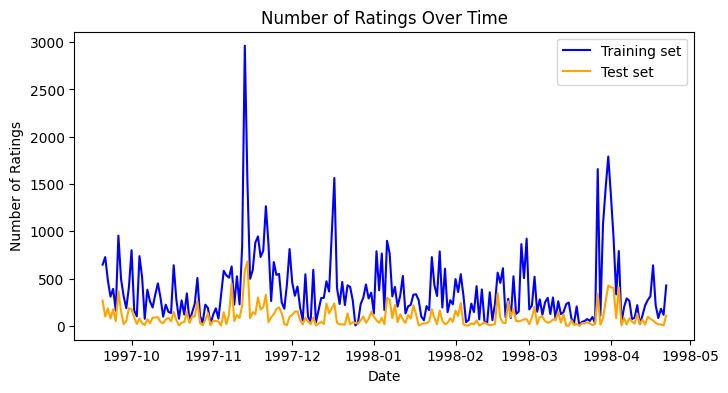

In [37]:
from pyspark.sql.functions import from_unixtime
print("\n************************** Time wise rating stats  **************************\n")

# chaning timestamp to date
training_with_date = training.withColumn("date", from_unixtime("timestamp").cast("date"))
test_with_date = test.withColumn("date", from_unixtime("timestamp").cast("date"))

# Counting of no. of ratings per date
ratings_per_date_train = training_with_date.groupBy("date").count().orderBy("date").toPandas()
ratings_per_date_test = test_with_date.groupBy("date").count().orderBy("date").toPandas()

# Ploting of line chart
plt.figure(figsize=(8, 4))
plt.plot(ratings_per_date_train["date"], ratings_per_date_train["count"], label='Training set', color='blue')
plt.plot(ratings_per_date_test["date"], ratings_per_date_test["count"], label='Test set', color='orange')

#Cosmetic changes
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings Over Time')
plt.legend()
plt.show()


Using the training set, train a model with the Alternating Least Squares method available in the Spark MLlib: [https://spark.apache.org/docs/latest/ml-collaborative-filtering.html](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html)

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

# Building of the recommendation model using ALS on the importated training data
#setting cold start strategy = 'drop' to avoid any NaN values from the evaluation metrics
als = ALS(rank=10, maxIter=10, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

Now compute the RMSE on the test dataset.


In [27]:
#using RMSE on the dataset for evalution purpose
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))


Root-mean-square error = 0.9371069906499119


In [28]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(rank=100, maxIter=10, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# YOUR CODE HERE
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9278462701804047


At this point, you can use the trained model to produce the top-K recommendations for each user.

In [29]:
regParam_list = [1, 0.3, 0.1, 0.03, 0.01]

for regParam in regParam_list:
  # Build the recommendation model using ALS on the training data
  # Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
  als = ALS(rank=100, maxIter=10, regParam=regParam, userCol="user_id", itemCol="item_id", ratingCol="rating",
            coldStartStrategy="drop")
  model = als.fit(training)

  # YOUR CODE HERE
  # Evaluate the model by computing the RMSE on the test data
  predictions = model.transform(test)
  evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                  predictionCol="prediction")
  rmse = evaluator.evaluate(predictions)
  print("Regularization parameter = {}, Root-mean-square error = {}".format(regParam, str(rmse)))


Regularization parameter = 1, Root-mean-square error = 1.379344968170541
Regularization parameter = 0.3, Root-mean-square error = 0.9908413506876436
Regularization parameter = 0.1, Root-mean-square error = 0.9278462701804102
Regularization parameter = 0.03, Root-mean-square error = 0.9774216867696286
Regularization parameter = 0.01, Root-mean-square error = 1.1381090350659808


In [30]:
# YOUR CODE HERE
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(rank=100, maxIter=10, regParam=0.1, userCol="user_id", itemCol="item_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# YOUR CODE HERE
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

# Generate top 1 movie recommendations for each user
userRecs = model.recommendForAllUsers(1)

In [31]:
userRecs.select('user_id', expr("recommendations['item_id']")[0].alias("item_id")).groupBy('item_id').count().sort(desc('count')).take(5)

[Row(item_id=1449, count=125),
 Row(item_id=313, count=77),
 Row(item_id=318, count=69),
 Row(item_id=50, count=68),
 Row(item_id=64, count=42)]

In [32]:
items.filter(items.item_id == 1449).take(5)

[Row(item_id=1449, movie='Pather Panchali (1955)')]

Once you have working code for each cell above, **head over to Gradescope, carefully read the questions, and submit your solution for this Colab**!